In [1]:
import os,sys
import torch
import importlib
from utils import options
from utils.util import log

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
argv = ['--group=ETH3D', '--pipeline=LevelS2fM', '--yaml=ETH3D', '--name=facade', '--data.dataset=ETH3D', '--data.scene=facade', '--sfm_mode=full', '--nbv_mode=ours', '--refine_again=false']
opt_cmd = options.parse_arguments(argv)
opt = options.set(opt_cmd=opt_cmd,safe_check=False)

model = importlib.import_module("pipelines.{}".format(opt.pipeline))
m = model.Model(opt)
m.load_dataset(opt)
m.restore_checkpoint(opt)
m.setup_visualizer(opt)
# m.train(opt)

setting configurations...
loading options/base.yaml...
loading options/LevelS2fM.yaml...
loading options/ETH3D.yaml...
* Ablate_config:
   * ba_trad: False
   * dual_field: False
   * refine_again: False
   * sdf_filter: True
   * tri_trad: False
* H: 1033
* RadF:
   * Hash_config:
      * config_file: options/config_hash_rad.json
   * arch:
      * layers: [None, 64, 64, 3]
      * skip: []
* Renderer:
   * rand_rays: 8192
* Res: 100
* SDF:
   * Hash_config:
      * config_file: options/config_hash_sdf.json
   * NN_Init:
      * bias: 2.5
      * scale_mlp: 5
      * tf_init: True
   * VolSDF:
      * beta_init: 0.05
      * beta_speed: 1.0
      * eps: 0.1
      * final_sample_intvs: 64
      * iters_max_st: 20
      * max_upsample_iter: 6
      * outside_scene: builtin
      * rescale: 1.0
      * sample_intvs: 128
      * sdf_threshold: 1e-3
      * volsdf_sampling: False
   * arch:
      * density_activ: softplus
      * layers: [None, 64, 16]
      * skip: []
* W: 1551
* arch:
* 

loading dataset...: 100%|██████████| 76/76 [00:21<00:00,  3.46it/s]


number of samples: 76
initializing weights from scratch...
setting up visualizers...


In [3]:
import importlib
import pdb
import numpy as np
import os, sys, time
import torch
import tqdm
import utils.util as util
from easydict import EasyDict as edict

from utils.util import log
import utils.camera as camera
from pipelines import base
from pipelines import Camera
from pipelines import Point3D
from pipelines import Initialization
from pipelines import Registration
from pipelines import BA
from pipelines import rendering_refine
from pipelines import Initialization_Trad
from pipelines import BA_Trad
from pipelines import Registration_Trad

var = m.load_matches(opt)
pose_graph_path = f"data/{opt.data.dataset}/{opt.data.scene}/pose_graph.npy"
pose_graph = np.load(pose_graph_path, allow_pickle=True)[:]

In [4]:
var.indx_init = pose_graph[:2]
var.imgs_init = m.train_data.all.image[var.indx_init]
var.kypts_init = [var.kypts[i] for i in var.indx_init]
var.intrs_init = m.train_data.all.intr[var.indx_init]
var.mchs_init = [var.matches[i] for i in var.indx_init]
var.inliers_init = [var.masks[i] for i in var.indx_init]
var.gt_depths = None
var.omn_depths = m.train_data.all.depth_omnidata[var.indx_init]
var.omn_norms = m.train_data.all.norm_omnidata[var.indx_init]

Text(0.5, 1.0, 'The Second Image')

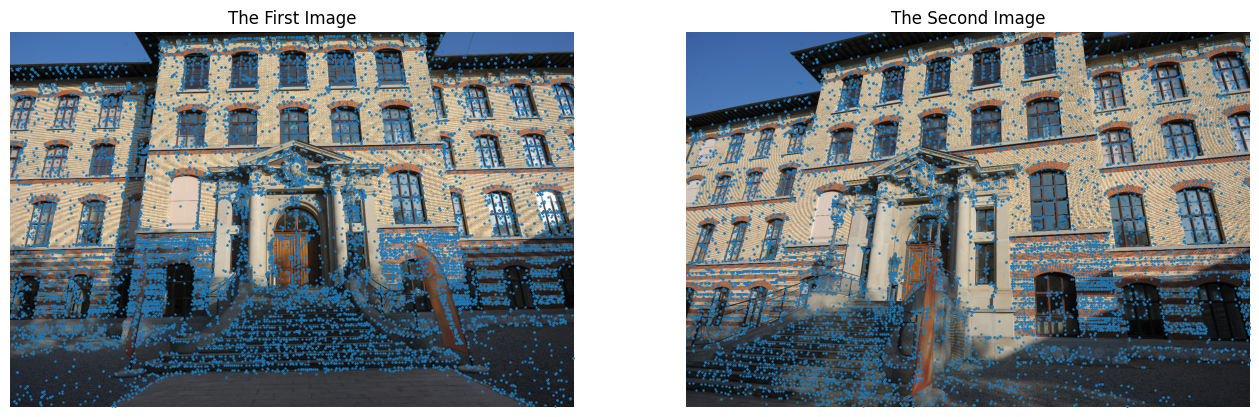

In [5]:
import matplotlib.pyplot as plt 
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
axes[0].imshow(var.imgs_init[0].permute((1,2,0)).cpu().numpy())
axes[0].axis('off')
axes[0].set_title('The First Image')
axes[0].scatter(var.kypts_init[0][:,0].cpu().numpy(), var.kypts_init[0][:,1].cpu().numpy(),s=0.5)
axes[1].imshow(var.imgs_init[1].permute((1,2,0)).cpu().numpy())
axes[1].scatter(var.kypts_init[1][:,0].cpu().numpy(), var.kypts_init[1][:,1].cpu().numpy(),s=0.5)
axes[1].axis('off')
axes[1].set_title('The Second Image')


In [6]:
Initializer = Initialization.Initializer(opt,m.camera_set,m.point_set,m.sdf_func,m.color_func,var,cam_info_reloaded=m.cam_info_reloaded)

/home/xn/anaconda3/envs/levels2fm/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1666642975993/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [7]:
Initializer.run(m.camera_set,m.point_set,m.sdf_func,m.color_func,Renderer=m.Renderer)

Initialization:   0%|          | 1/500 [00:00<05:45,  1.44it/s]

5 points algo rot_error:0.03956468030810356
5 points algo translation_error:0.1528813511442228
our algo rot_error:0.02797645330429077
our algo translation_error:0.1532333940267563
{'PSNR': 10.66928482055664, 'reproj_error': 197.91697692871094, 'sdf_surf': 0.01570148766040802, 'eikonal_loss': 0.8386491537094116, 'rgb': 0.26677417755126953, 'DC_Loss': 0.07629722356796265}


Initialization:   2%|▏         | 12/500 [00:02<01:23,  5.86it/s]

{'PSNR': 12.368114471435547, 'reproj_error': 169.79042053222656, 'sdf_surf': 0.007425772957503796, 'eikonal_loss': 0.7913753986358643, 'rgb': 0.19845299422740936, 'DC_Loss': 0.06145890802145004}


Initialization:   4%|▍         | 22/500 [00:04<01:20,  5.91it/s]

{'PSNR': 12.702540397644043, 'reproj_error': 134.071044921875, 'sdf_surf': 0.003351965919137001, 'eikonal_loss': 0.3609139919281006, 'rgb': 0.19129006564617157, 'DC_Loss': 0.04633849859237671}


Initialization:   6%|▋         | 32/500 [00:05<01:18,  5.98it/s]

{'PSNR': 12.731818199157715, 'reproj_error': 90.76201629638672, 'sdf_surf': 0.00148302991874516, 'eikonal_loss': 0.31876546144485474, 'rgb': 0.1901971697807312, 'DC_Loss': 0.03296234458684921}


Initialization:   8%|▊         | 42/500 [00:07<01:16,  5.97it/s]

{'PSNR': 12.840837478637695, 'reproj_error': 59.35774612426758, 'sdf_surf': 0.000877783284522593, 'eikonal_loss': 0.2963619530200958, 'rgb': 0.187944233417511, 'DC_Loss': 0.025014782324433327}


Initialization:  10%|█         | 52/500 [00:09<01:15,  5.93it/s]

{'PSNR': 13.145111083984375, 'reproj_error': 39.26349639892578, 'sdf_surf': 0.00067555793793872, 'eikonal_loss': 0.2911846935749054, 'rgb': 0.1806325614452362, 'DC_Loss': 0.022635484114289284}


Initialization:  12%|█▏        | 62/500 [00:10<01:13,  5.98it/s]

{'PSNR': 14.223037719726562, 'reproj_error': 21.665584564208984, 'sdf_surf': 0.0006309200543910265, 'eikonal_loss': 0.3077177405357361, 'rgb': 0.15627925097942352, 'DC_Loss': 0.026100870221853256}


Initialization:  14%|█▍        | 72/500 [00:12<01:11,  5.95it/s]

{'PSNR': 15.503459930419922, 'reproj_error': 9.62853717803955, 'sdf_surf': 0.0007163435220718384, 'eikonal_loss': 0.32914799451828003, 'rgb': 0.12528252601623535, 'DC_Loss': 0.033254627138376236}


Initialization:  16%|█▋        | 82/500 [00:14<01:09,  5.99it/s]

{'PSNR': 16.661975860595703, 'reproj_error': 5.9316582679748535, 'sdf_surf': 0.0013502476504072547, 'eikonal_loss': 0.33323433995246887, 'rgb': 0.1077553853392601, 'DC_Loss': 0.038194283843040466}


Initialization:  18%|█▊        | 92/500 [00:15<01:08,  5.97it/s]

{'PSNR': 17.34128189086914, 'reproj_error': 8.422833442687988, 'sdf_surf': 0.007662185933440924, 'eikonal_loss': 0.33314186334609985, 'rgb': 0.09747950732707977, 'DC_Loss': 0.04041588678956032}


Initialization:  20%|██        | 102/500 [00:17<01:06,  5.96it/s]

{'PSNR': 17.55897331237793, 'reproj_error': 8.673277854919434, 'sdf_surf': 0.007952486164867878, 'eikonal_loss': 0.32684361934661865, 'rgb': 0.09259754419326782, 'DC_Loss': 0.042142704129219055}


Initialization:  22%|██▏       | 112/500 [00:19<01:05,  5.88it/s]

{'PSNR': 17.939470291137695, 'reproj_error': 7.757449150085449, 'sdf_surf': 0.00736239505931735, 'eikonal_loss': 0.3186666965484619, 'rgb': 0.08746399730443954, 'DC_Loss': 0.04374070465564728}


Initialization:  24%|██▍       | 122/500 [00:21<01:03,  5.95it/s]

{'PSNR': 17.96099090576172, 'reproj_error': 6.576944351196289, 'sdf_surf': 0.005612930748611689, 'eikonal_loss': 0.31429600715637207, 'rgb': 0.08645087480545044, 'DC_Loss': 0.043760716915130615}


Initialization:  26%|██▋       | 132/500 [00:22<01:01,  5.97it/s]

{'PSNR': 18.21845817565918, 'reproj_error': 5.962925910949707, 'sdf_surf': 0.004968164023011923, 'eikonal_loss': 0.30987614393234253, 'rgb': 0.08384468406438828, 'DC_Loss': 0.04488927498459816}


Initialization:  28%|██▊       | 142/500 [00:24<01:00,  5.96it/s]

{'PSNR': 18.32899284362793, 'reproj_error': 5.358686923980713, 'sdf_surf': 0.0049567013047635555, 'eikonal_loss': 0.3067588210105896, 'rgb': 0.08122316002845764, 'DC_Loss': 0.045408885926008224}


Initialization:  30%|███       | 152/500 [00:26<00:58,  5.96it/s]

{'PSNR': 18.381046295166016, 'reproj_error': 4.825823783874512, 'sdf_surf': 0.004466285929083824, 'eikonal_loss': 0.3047310709953308, 'rgb': 0.08060877025127411, 'DC_Loss': 0.04509986564517021}


Initialization:  32%|███▏      | 162/500 [00:27<00:56,  5.96it/s]

{'PSNR': 18.27184295654297, 'reproj_error': 4.0332255363464355, 'sdf_surf': 0.003409822704270482, 'eikonal_loss': 0.30165979266166687, 'rgb': 0.08116194605827332, 'DC_Loss': 0.04635794833302498}


Initialization:  34%|███▍      | 172/500 [00:29<00:55,  5.92it/s]

{'PSNR': 18.751941680908203, 'reproj_error': 3.4698164463043213, 'sdf_surf': 0.003418669570237398, 'eikonal_loss': 0.2995036840438843, 'rgb': 0.0770384669303894, 'DC_Loss': 0.04676319286227226}


Initialization:  36%|███▋      | 182/500 [00:31<00:53,  5.95it/s]

{'PSNR': 18.6162166595459, 'reproj_error': 2.875575542449951, 'sdf_surf': 0.0026409216225147247, 'eikonal_loss': 0.29794806241989136, 'rgb': 0.07637208700180054, 'DC_Loss': 0.04754091426730156}


Initialization:  38%|███▊      | 192/500 [00:32<00:51,  5.99it/s]

{'PSNR': 18.8935546875, 'reproj_error': 2.646820545196533, 'sdf_surf': 0.0025222671683877707, 'eikonal_loss': 0.2970889210700989, 'rgb': 0.07391952723264694, 'DC_Loss': 0.047397345304489136}


Initialization:  40%|████      | 202/500 [00:34<00:49,  5.97it/s]

{'PSNR': 18.6968994140625, 'reproj_error': 2.246523141860962, 'sdf_surf': 0.0021378423552960157, 'eikonal_loss': 0.29555583000183105, 'rgb': 0.07618622481822968, 'DC_Loss': 0.047315407544374466}


Initialization:  42%|████▏     | 212/500 [00:36<00:48,  5.96it/s]

{'PSNR': 18.79953384399414, 'reproj_error': 1.8472023010253906, 'sdf_surf': 0.0019840849563479424, 'eikonal_loss': 0.29479777812957764, 'rgb': 0.07521551847457886, 'DC_Loss': 0.04677557200193405}


Initialization:  44%|████▍     | 222/500 [00:37<00:46,  5.96it/s]

{'PSNR': 19.05254554748535, 'reproj_error': 1.7256344556808472, 'sdf_surf': 0.0018224508967250586, 'eikonal_loss': 0.29387301206588745, 'rgb': 0.0730963796377182, 'DC_Loss': 0.04844966530799866}


Initialization:  46%|████▋     | 232/500 [00:39<00:45,  5.93it/s]

{'PSNR': 19.06080436706543, 'reproj_error': 1.6530039310455322, 'sdf_surf': 0.0019000406609848142, 'eikonal_loss': 0.29291659593582153, 'rgb': 0.073065385222435, 'DC_Loss': 0.04845863953232765}


Initialization:  48%|████▊     | 242/500 [00:41<00:43,  5.97it/s]

{'PSNR': 19.12812042236328, 'reproj_error': 1.4697999954223633, 'sdf_surf': 0.0017484965501353145, 'eikonal_loss': 0.2925441861152649, 'rgb': 0.07227708399295807, 'DC_Loss': 0.048946402966976166}


Initialization:  50%|█████     | 252/500 [00:42<00:41,  5.96it/s]

{'PSNR': 18.99257469177246, 'reproj_error': 1.1449215412139893, 'sdf_surf': 0.0016828309744596481, 'eikonal_loss': 0.2917559742927551, 'rgb': 0.07241897284984589, 'DC_Loss': 0.04773280769586563}


Initialization:  52%|█████▏    | 262/500 [00:44<00:39,  5.97it/s]

{'PSNR': 19.312602996826172, 'reproj_error': 1.0512418746948242, 'sdf_surf': 0.001551416120491922, 'eikonal_loss': 0.29065173864364624, 'rgb': 0.0696391761302948, 'DC_Loss': 0.04923152178525925}


Initialization:  54%|█████▍    | 272/500 [00:46<00:38,  5.95it/s]

{'PSNR': 19.132286071777344, 'reproj_error': 1.0895079374313354, 'sdf_surf': 0.001476291916333139, 'eikonal_loss': 0.28948545455932617, 'rgb': 0.07066991925239563, 'DC_Loss': 0.04906328022480011}


Initialization:  56%|█████▋    | 282/500 [00:47<00:36,  5.94it/s]

{'PSNR': 19.22664451599121, 'reproj_error': 1.0189275741577148, 'sdf_surf': 0.0014798602787777781, 'eikonal_loss': 0.28846174478530884, 'rgb': 0.06932317465543747, 'DC_Loss': 0.04916359484195709}


Initialization:  58%|█████▊    | 292/500 [00:49<00:35,  5.94it/s]

{'PSNR': 19.300369262695312, 'reproj_error': 0.9455248117446899, 'sdf_surf': 0.0012816149974241853, 'eikonal_loss': 0.28827011585235596, 'rgb': 0.06888332962989807, 'DC_Loss': 0.04935314878821373}


Initialization:  60%|██████    | 302/500 [00:51<00:33,  5.94it/s]

{'PSNR': 19.353668212890625, 'reproj_error': 0.9887282252311707, 'sdf_surf': 0.0013518129708245397, 'eikonal_loss': 0.28834667801856995, 'rgb': 0.06878769397735596, 'DC_Loss': 0.0499524287879467}


Initialization:  62%|██████▏   | 312/500 [00:52<00:31,  5.94it/s]

{'PSNR': 19.216854095458984, 'reproj_error': 0.9045243263244629, 'sdf_surf': 0.0012990284012630582, 'eikonal_loss': 0.28723880648612976, 'rgb': 0.06961476802825928, 'DC_Loss': 0.04981600120663643}


Initialization:  64%|██████▍   | 322/500 [00:54<00:30,  5.93it/s]

{'PSNR': 19.451868057250977, 'reproj_error': 0.852300226688385, 'sdf_surf': 0.001237913384102285, 'eikonal_loss': 0.28723329305648804, 'rgb': 0.06779539585113525, 'DC_Loss': 0.05027575418353081}


Initialization:  66%|██████▋   | 332/500 [00:56<00:28,  5.94it/s]

{'PSNR': 19.649330139160156, 'reproj_error': 0.8426052927970886, 'sdf_surf': 0.0012106932699680328, 'eikonal_loss': 0.2863565981388092, 'rgb': 0.06505703926086426, 'DC_Loss': 0.05075953155755997}


Initialization:  68%|██████▊   | 342/500 [00:57<00:26,  5.96it/s]

{'PSNR': 19.720199584960938, 'reproj_error': 0.8645285964012146, 'sdf_surf': 0.0012514741392806172, 'eikonal_loss': 0.2862105965614319, 'rgb': 0.06594505906105042, 'DC_Loss': 0.049765121191740036}


Initialization:  70%|███████   | 352/500 [00:59<00:24,  5.95it/s]

{'PSNR': 19.549470901489258, 'reproj_error': 0.8344569802284241, 'sdf_surf': 0.0011523704743012786, 'eikonal_loss': 0.2859977185726166, 'rgb': 0.06662642955780029, 'DC_Loss': 0.04994994401931763}


Initialization:  72%|███████▏  | 362/500 [01:01<00:23,  5.97it/s]

{'PSNR': 19.564250946044922, 'reproj_error': 0.8403384685516357, 'sdf_surf': 0.0010861220071092248, 'eikonal_loss': 0.2857361435890198, 'rgb': 0.06685202568769455, 'DC_Loss': 0.04939606413245201}


Initialization:  74%|███████▍  | 372/500 [01:03<00:21,  5.95it/s]

{'PSNR': 19.56550407409668, 'reproj_error': 0.7948386073112488, 'sdf_surf': 0.0010383989429101348, 'eikonal_loss': 0.2843717932701111, 'rgb': 0.0662471279501915, 'DC_Loss': 0.05091913789510727}


Initialization:  76%|███████▋  | 382/500 [01:04<00:19,  5.93it/s]

{'PSNR': 19.927549362182617, 'reproj_error': 0.7341495752334595, 'sdf_surf': 0.001094544306397438, 'eikonal_loss': 0.28452906012535095, 'rgb': 0.06347713619470596, 'DC_Loss': 0.050692468881607056}


Initialization:  78%|███████▊  | 392/500 [01:06<00:18,  5.94it/s]

{'PSNR': 20.075807571411133, 'reproj_error': 0.7819310426712036, 'sdf_surf': 0.0010761136654764414, 'eikonal_loss': 0.2839924097061157, 'rgb': 0.06263131648302078, 'DC_Loss': 0.0514366552233696}


Initialization:  80%|████████  | 402/500 [01:08<00:16,  5.97it/s]

{'PSNR': 19.917139053344727, 'reproj_error': 0.7298182845115662, 'sdf_surf': 0.0011080901604145765, 'eikonal_loss': 0.28442245721817017, 'rgb': 0.06271753460168839, 'DC_Loss': 0.05179741978645325}


Initialization:  82%|████████▏ | 412/500 [01:09<00:14,  5.95it/s]

{'PSNR': 19.73618507385254, 'reproj_error': 0.7652429938316345, 'sdf_surf': 0.001057217363268137, 'eikonal_loss': 0.28417301177978516, 'rgb': 0.06410710513591766, 'DC_Loss': 0.04988875240087509}


Initialization:  84%|████████▍ | 422/500 [01:11<00:13,  5.95it/s]

{'PSNR': 19.66828155517578, 'reproj_error': 0.7425253987312317, 'sdf_surf': 0.0010306137846782804, 'eikonal_loss': 0.2837190628051758, 'rgb': 0.06457307189702988, 'DC_Loss': 0.05106009542942047}


Initialization:  86%|████████▋ | 432/500 [01:13<00:11,  5.96it/s]

{'PSNR': 19.809486389160156, 'reproj_error': 0.7290653586387634, 'sdf_surf': 0.001006009872071445, 'eikonal_loss': 0.2833844721317291, 'rgb': 0.06394284218549728, 'DC_Loss': 0.0512990765273571}


Initialization:  88%|████████▊ | 441/500 [01:14<00:09,  5.95it/s]

{'PSNR': 20.080276489257812, 'reproj_error': 0.7061693668365479, 'sdf_surf': 0.0009635656024329364, 'eikonal_loss': 0.28280019760131836, 'rgb': 0.06160754710435867, 'DC_Loss': 0.05261941999197006}


Initialization:  90%|█████████ | 452/500 [01:16<00:08,  5.95it/s]

{'PSNR': 20.2174015045166, 'reproj_error': 0.7292574644088745, 'sdf_surf': 0.0009558855090290308, 'eikonal_loss': 0.2830073833465576, 'rgb': 0.06031124293804169, 'DC_Loss': 0.05195319280028343}


Initialization:  92%|█████████▏| 462/500 [01:18<00:06,  5.96it/s]

{'PSNR': 19.954898834228516, 'reproj_error': 0.7008634209632874, 'sdf_surf': 0.0009106551297008991, 'eikonal_loss': 0.28243619203567505, 'rgb': 0.06187688559293747, 'DC_Loss': 0.05167389288544655}


Initialization:  94%|█████████▍| 472/500 [01:19<00:04,  5.88it/s]

{'PSNR': 20.195507049560547, 'reproj_error': 0.6733726859092712, 'sdf_surf': 0.0009235178586095572, 'eikonal_loss': 0.28229790925979614, 'rgb': 0.061351023614406586, 'DC_Loss': 0.051061153411865234}


Initialization:  96%|█████████▋| 482/500 [01:21<00:03,  5.94it/s]

{'PSNR': 19.88245964050293, 'reproj_error': 0.688668429851532, 'sdf_surf': 0.0009567951783537865, 'eikonal_loss': 0.2828395962715149, 'rgb': 0.06239775940775871, 'DC_Loss': 0.05198286473751068}


Initialization:  98%|█████████▊| 492/500 [01:23<00:01,  5.93it/s]

{'PSNR': 20.01016616821289, 'reproj_error': 0.6958440542221069, 'sdf_surf': 0.0009454847313463688, 'eikonal_loss': 0.2825181484222412, 'rgb': 0.062391191720962524, 'DC_Loss': 0.05146139860153198}


----------------final loss-----------------
{'PSNR': 20.061721801757812, 'reproj_error': 0.6702826619148254, 'sdf_surf': 0.0009842123836278915, 'eikonal_loss': 0.28222373127937317, 'rgb': 0.06093555688858032, 'DC_Loss': 0.05121305212378502, 'all': 89.97785186767578}
Triangulation ratio 546/552
rot_error:0.02797645330429077
t_error:0.1532333940267563


In [10]:
camera0 = m.camera_set.cameras[0]
camera1 = m.camera_set.cameras[1]
pose0 = camera0.get_pose().detach()[0]
pose1 = camera1.get_pose().detach()[0]
points3D = torch.cat([_.xyz for _ in m.point_set.pointset])

In [11]:
from notebooks import vis_3d

In [12]:
fig = vis_3d.init_figure()
vis_3d.plot_points(fig, points3D.cpu().numpy(), color='rgba(255,0,0,1)', ps=1)
vis_3d.plot_camera(fig, pose0.cpu().numpy()[:3,:3], pose0.cpu().numpy()[:3,3], camera0.intrinsic.cpu().numpy(), color='rgba(0,255,0,1)', name='Camera 0')
vis_3d.plot_camera(fig, pose1.cpu().numpy()[:3,:3], pose1.cpu().numpy()[:3,3], camera1.intrinsic.cpu().numpy(), color='rgba(0,128,64,1)', name='Camera 1')
fig.show()